# Introduction.

These are some (modest) attempts at participating in Jigsaw's toxic comments classification problem. For now, I am not using any external data, only the training data given (which is limiting as it's a tiny dataset).

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
import keras
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import h5py

Using TensorFlow backend.


# Load Data

In [2]:
ls data

boardgame-comments.csv
boardgame-frequent-user-comments.csv
glove.6B.50d.txt
glove.6B.50d.txt.zip
sample_submission.csv
sample_submission.csv.zip
test.csv
test.csv.zip
toxicity_annotated_comments.tsv
toxicity_annotated_comments_unanimous.tsv
toxicity_annotations.tsv
toxicity_annotations_unanimous.tsv
toxicity_worker_demographics.tsv
train.csv
train.csv.zip


In [3]:
df = pd.read_csv('data/toxicity_annotated_comments.tsv', sep='\t')

In [4]:
df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [5]:
len(df)

159686

In [6]:
scores = pd.read_csv('data/toxicity_annotations.tsv',  sep='\t')

In [7]:
scores.head(10)

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0
5,2232.0,1508,0,1.0
6,2232.0,772,0,1.0
7,2232.0,680,0,0.0
8,2232.0,405,0,1.0
9,2232.0,4020,1,-1.0


In [8]:
scores.drop_duplicates(subset='rev_id', inplace=True)

In [9]:
len(scores)

159686

In [10]:
df = df.merge(scores, on='rev_id', how='inner')

In [11]:
len(df)

159686

In [12]:
df.head(10)

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,723,0,0.0
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train,500,0,0.0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,2596,0,1.0
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train,1642,0,1.0
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,202,0,1.0
5,35367.0,`:In an interpreted language your source code ...,2002,True,article,random,dev,1408,0,1.0
6,37330.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENI fixe...,2002,True,article,random,train,691,0,0.0
7,37346.0,`If they are ``indisputable`` then why does th...,2002,True,article,random,train,1108,0,0.0
8,37675.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,dev,403,0,1.0
9,44377.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThe co...,2002,True,article,random,train,1927,0,2.0


In [13]:
df.drop(columns=['year', 'logged_in', 'split', 'ns', 'sample'], inplace=True)

In [14]:
df.head(10)

,rev_id,comment,worker_id,toxicity,toxicity_score
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,723,0,0.0
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,500,0,0.0
2,8953.0,Elected or Electoral? JHK,2596,0,1.0
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,1642,0,1.0
4,28959.0,Please relate the ozone hole to increases in c...,202,0,1.0
5,35367.0,`:In an interpreted language your source code ...,1408,0,1.0
6,37330.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENI fixe...,691,0,0.0
7,37346.0,`If they are ``indisputable`` then why does th...,1108,0,0.0
8,37675.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,403,0,1.0
9,44377.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThe co...,1927,0,2.0


In [15]:
df['comment'] = df['comment'].apply(lambda x: re.sub('NEWLINE_TOKEN', '', x))

In [16]:
df['toxic'] = df['toxicity_score'].apply(lambda x: int(x < 0))

In [17]:
df.drop(columns=['toxicity', 'toxicity_score'], inplace=True)

In [18]:
df.sort_values(['toxic'], ascending=False, inplace=True)

In [19]:
df.head(10)

,rev_id,comment,worker_id,toxic
43160,138798055.0,`==Ck lostsword's RfA - Thanks=={| align=``cen...,3208,1
124302,485585361.0,== THIS USER IS A PLANT FROM BRUCE PERENS AND ...,1236,1
124227,485198090.0,"this Baboon43 is from Scarborough, Toronto, C...",3869,1
41554,132533129.0,"I really do not see how i am acting immature, ...",144,1
124217,485118928.0,"Hello BeCritical,Well, I have to say that aft...",24,1
124215,485070371.0,== fucking nutcase ==you're a fucking nutcase,1513,1
124213,485069083.0,== nutcase ==you're a sick bloody nutcase,2939,1
124212,485068088.0,== NUTCASE ==YOU'RE A SICK BLOODY NUTCASE,2334,1
124209,485055520.0,"Oh fuck, not Samuel Johnson. Do you have any i...",3340,1
41573,132583618.0,== Chinese American Food Society ==I received ...,1937,1


# Pre-process

In [20]:
simple_tokens = df.comment.apply(gensim.utils.simple_preprocess)

In [21]:
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)

In [22]:
tokenized_text = list(tokenizer[simple_tokens])

In [23]:
tokenized_text[0]

['ck',
 'lostsword',
 'rfa',
 'thanks',
 'align_center',
 'width_style',
 'border',
 'ff',
 'solid',
 'px_moz',
 'border_radius',
 'px',
 'background',
 'ebebeb',
 'text_align',
 'left',
 'color_ff',
 'padding_px',
 'rowspan',
 'thanks',
 'very_much',
 'for',
 'your',
 'support',
 'in',
 'my',
 'recent_rfa',
 'which',
 'passed',
 'successfully',
 'at',
 'making',
 'me',
 'wikipedia',
 'th',
 'administrator',
 'your',
 'comments',
 'were',
 'much_appreciated',
 'and',
 'will',
 'endeavour',
 'to',
 'fulfil',
 'your',
 'expectations',
 'as',
 'an_admin']

In [24]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

In [25]:
df.columns

Index(['rev_id', 'comment', 'worker_id', 'toxic'], dtype='object')

In [26]:
TARGET_CLASSES = ['toxic']
targets = df[TARGET_CLASSES].values

In [27]:
targets

array([[1],
       [1],
       [1],
       ..., 
       [0],
       [0],
       [0]])

# Analysis

(0, 400)

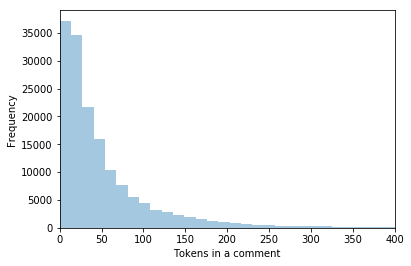

In [28]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

# Training word2vec on comment data.

In [29]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)

In [30]:
word2vec.wv.most_similar('citation')

[('reference', 0.8477044105529785),
 ('source', 0.8028237819671631),
 ('citations', 0.7823623418807983),
 ('references', 0.7731161117553711),
 ('footnote', 0.7572417259216309),
 ('ref', 0.7561527490615845),
 ('verification', 0.7535486221313477),
 ('reliable_source', 0.7340558767318726),
 ('secondary_source', 0.7105909585952759),
 ('sources', 0.7009351253509521)]

In [51]:
word2vec.wv.most_similar('stupid')

[('dumb', 0.8123797178268433),
 ('crazy', 0.7846869230270386),
 ('pathetic', 0.7510919570922852),
 ('funny', 0.7441648840904236),
 ('silly', 0.7424641847610474),
 ('retarded', 0.7356431484222412),
 ('lazy', 0.7324571013450623),
 ('useless', 0.7085483074188232),
 ('worthless', 0.6991524696350098),
 ('annoying', 0.6897914409637451)]

# word2vec-based model

Aggregate word embeddings per comment (~ tf-idf weighted averaging), and use that as an input feature in a neural net with one hidden layer.

In [32]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [33]:
features.shape

(159686, 100)

In [34]:
targets.shape

(159686, 1)

In [35]:
len(TARGET_CLASSES)

1

In [36]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model.fit(features, targets, epochs=10, validation_split=0.1)

Train on 143717 samples, validate on 15969 samples
Epoch 1/10
143717/143717 [==============================] - 6s 45us/step - loss: 0.3677 - acc: 0.8547 - val_loss: 0.1645 - val_acc: 0.9698
Epoch 2/10
143717/143717 [==============================] - 6s 41us/step - loss: 0.3485 - acc: 0.8611 - val_loss: 0.1058 - val_acc: 0.9852
Epoch 3/10
143717/143717 [==============================] - 6s 43us/step - loss: 0.3446 - acc: 0.8631 - val_loss: 0.1457 - val_acc: 0.9731
Epoch 4/10
143717/143717 [==============================] - 7s 46us/step - loss: 0.3410 - acc: 0.8649 - val_loss: 0.1309 - val_acc: 0.9820
Epoch 5/10
143717/143717 [==============================] - 6s 45us/step - loss: 0.3381 - acc: 0.8661 - val_loss: 0.0931 - val_acc: 0.9875
Epoch 6/10
143717/143717 [==============================] - 6s 43us/step - loss: 0.3365 - acc: 0.8672 - val_loss: 0.0946 - val_acc: 0.9867
Epoch 7/10
143717/143717 [==============================] - 6s 43us/step - loss: 0.3355 - acc: 0.8678 - val_loss: 0

# Sequential models

Simply averaging embeddings across all terms in a comment loses interactions that can occur between words, and the importance of their position. Because of this, we will now experiment with position-aware models: LSTM and CNN.

In [38]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [39]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [40]:
max_idx = max(c for d in docs for c in d)
max_idx

191587

In [41]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

## CNN

In [42]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.fit(padded_docs, targets, batch_size=512, epochs=20, validation_split=0.1)

Train on 143717 samples, validate on 15969 samples
Epoch 1/20
143717/143717 [==============================] - 126s 874us/step - loss: 0.6820 - acc: 0.8612 - val_loss: 0.1401 - val_acc: 1.0000
Epoch 2/20
143717/143717 [==============================] - 126s 877us/step - loss: 0.3031 - acc: 0.8925 - val_loss: 0.0654 - val_acc: 0.9988
Epoch 3/20
143717/143717 [==============================] - 126s 876us/step - loss: 0.2572 - acc: 0.9090 - val_loss: 0.1257 - val_acc: 0.9811
Epoch 4/20
143717/143717 [==============================] - 126s 878us/step - loss: 0.2265 - acc: 0.9219 - val_loss: 0.1161 - val_acc: 0.9733
Epoch 5/20
143717/143717 [==============================] - 126s 879us/step - loss: 0.2037 - acc: 0.9321 - val_loss: 0.1531 - val_acc: 0.9625
Epoch 6/20
143717/143717 [==============================] - 127s 882us/step - loss: 0.1834 - acc: 0.9422 - val_loss: 0.2367 - val_acc: 0.9306
Epoch 7/20
143717/143717 [==============================] - 123s 855us/step - loss: 0.1679 - acc:

# Save Model

In [44]:
import h5py
model.save_weights('models/cnn_model.h5')

In [45]:
model.load_weights('models/cnn_model.h5')

In [46]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

In [47]:
def predict(comment):
    test_input = [comment_to_sequential_input(comment).reshape(1, -1)]
    for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
        print("{}: {:.2f}%".format(target_class, score * 100))

In [67]:
comment = "Why are we having all these people from shit hole countries come here?"
predict(comment)

toxic: 67.97%


In [65]:
comment = df.iloc[5].comment
print(comment)
predict(comment)

== fucking nutcase ==you're a fucking nutcase
toxic: 100.00%


In [55]:
comment = "Now is the time for all good persons to come to the aid of their country"
predict(comment)

toxic: 12.44%


In [ ]:
test_inputs = np.array([comment_to_sequential_input(doc) for doc in df_test.comment_text])

In [ ]:
test_outputs = model.predict_classes(test_inputs)

In [ ]:
test_outputs[0]

In [ ]:
output_df = df_test.reset_index()[['id']].copy()

In [ ]:
for i, target_class in enumerate(TARGET_CLASSES):
    output_df[target_class] = test_outputs[:, i]

In [ ]:
output_df[output_df.toxic > 0.5].sample(10, random_state=0).merge(df_test.reset_index(), on='id')

In [ ]:
output_df.to_csv('submissions/cnn_0.csv', index=False)

# Annex

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution1D, Dense

model = Sequential()
model.add(Embedding(word2vec.vector_size))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def tokens_to_embedding(tokens):
    embeddings = [word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens if t in word2vec.wv.vocab]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec.vector_size)

def text_to_embedding(text):
    return tokens_to_embedding(tokenizer[gensim.utils.simple_preprocess(text)])

text = 'hello moroccan friend is just a regular message without any insults'
model.predict(text_to_embedding(text).reshape(1, -1))

In [ ]:
test_tokens = tokenizer[df_test.comment_text.apply(gensim.utils.simple_preprocess)]

In [ ]:
test_features = [tokens_to_embedding(tokens) for tokens in test_tokens]